# MALCOM Lab Session 1

# Neural Network Implementation and Training
In this lab session, we will develop a simple neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [1]:
# Setup

import numpy as np
import matplotlib.pyplot as plt

from malcom.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We will use the class `TwoLayerNet` in the file `malcom/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. We will start with initializing toy data and a toy model, which we will use to further develop the neural network implementation.

In [2]:
# We create a small network and some toy data to check our implementations.
# Random seed is set for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()
print(y)

[0 1 2 2 1]


# Forward pass: compute scores
Open the file `malcom/neural_net.py` and look at the method `TwoLayerNet.loss`. This function takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [3]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('Correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small, less than 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and the regularization loss.

In [4]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# This should be very small, less than 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7985612998927536e-13


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. To check that the forward pass has been implemented correctly, you can debug your backward pass using a numeric gradient check:

In [5]:
from malcom.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# the analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 3.561318e-09
b1 max relative error: 2.738421e-09
W2 max relative error: 3.440708e-09
b2 max relative error: 4.447646e-11


# Neural Network Training
To train the neural network, we will use stochastic gradient descent (SGD). Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. 

You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on some toy data. The expected training loss should be less than 0.02.

Final training loss:  0.0007311789655197494


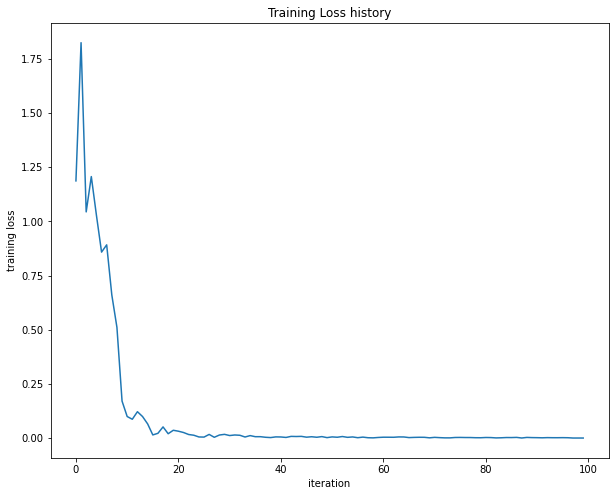

In [10]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6, batch_size=3,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# CIFAR-10 Data Loading
We will now train the implemented neural network in a real dataset, the widely used CIFAR-10.
You can download this dataset at: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Then, you can put it in the folder malcom/datasets (or anywhere else you want, but then you will need to change the path in the below code).

In [11]:
from malcom.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    This will allows us to load the CIFAR-10 dataset and perform preprocessing to prepare
    it for the two-layer neural net classifier.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'malcom/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Network Training
To train our network we will use (as before) SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [12]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302939
iteration 100 / 1000: loss 2.302427
iteration 200 / 1000: loss 2.298095
iteration 300 / 1000: loss 2.253179
iteration 400 / 1000: loss 2.152041
iteration 500 / 1000: loss 2.115062
iteration 600 / 1000: loss 2.067323
iteration 700 / 1000: loss 2.031150
iteration 800 / 1000: loss 1.968564
iteration 900 / 1000: loss 1.962258
Validation accuracy:  0.29


# Training Debugging
With the default parameters set above, the validation accuracy should be around 0.29 on the validation set. This is a relatively poor performance.

One strategy to understand where is the problem is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. 

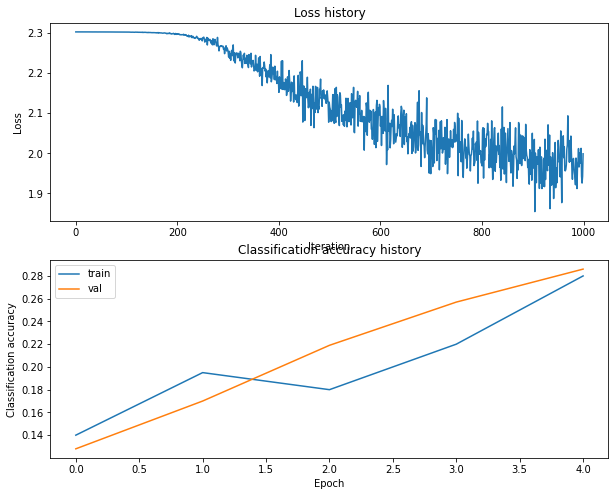

In [13]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

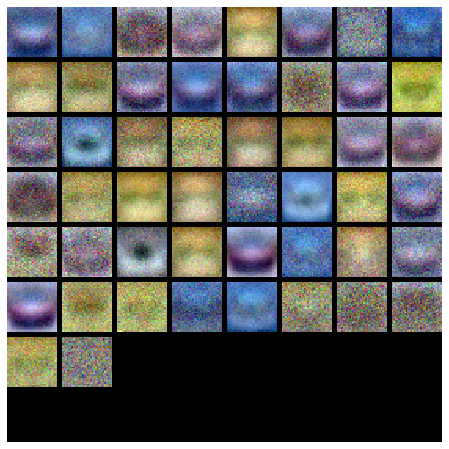

In [14]:
from malcom.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Hyperparameters tuning

**What's wrong?**. Looking at the visualizations above, we observe that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how these hyperparameters affect the final performance is an important task in Neural Networks - one would need a lot of practice and experience to get this skill. 
Here, we will experiment with different values of the various hyperparameters, including hidden layer size, learning rate, number of training epochs, and regularization strength. 
You might also consider tuning the learning rate decay (but even without this, you should be able to get good performance).

**Target accuracy**. The target classification accuracy to be achieved should be greater than 48% on the validation set. 

**Experiment**: The goal here is to get the best result possible on CIFAR-10. The best performance, with a more elaborated network, should be around 52%. 
Students with prior ML background could also implement various techniques to improve performance (e.g. PCA to reduce dimensionality, dropout, adding features to the solver, etc.). This is not needed though for getting good performance, unless we want to really approach the reference accuracy value.

**Explain your hyperparameter tuning process below.**

$\color{blue}{\textit {Your Answer}}$ TO BE COMPLETED

iteration 0 / 3000: loss 2.304102
iteration 100 / 3000: loss 1.968431
iteration 200 / 3000: loss 1.703761
iteration 300 / 3000: loss 1.668053
iteration 400 / 3000: loss 1.568027
iteration 500 / 3000: loss 1.642676
iteration 600 / 3000: loss 1.657947
iteration 700 / 3000: loss 1.504057
iteration 800 / 3000: loss 1.493732
iteration 900 / 3000: loss 1.565593
iteration 1000 / 3000: loss 1.523051
iteration 1100 / 3000: loss 1.383176
iteration 1200 / 3000: loss 1.426967
iteration 1300 / 3000: loss 1.480276
iteration 1400 / 3000: loss 1.355451
iteration 1500 / 3000: loss 1.398384
iteration 1600 / 3000: loss 1.398379
iteration 1700 / 3000: loss 1.464833
iteration 1800 / 3000: loss 1.308358
iteration 1900 / 3000: loss 1.536428
iteration 2000 / 3000: loss 1.327136
iteration 2100 / 3000: loss 1.343575
iteration 2200 / 3000: loss 1.283739
iteration 2300 / 3000: loss 1.346581
iteration 2400 / 3000: loss 1.427653
iteration 2500 / 3000: loss 1.221323
iteration 2600 / 3000: loss 1.324477
iteration 270

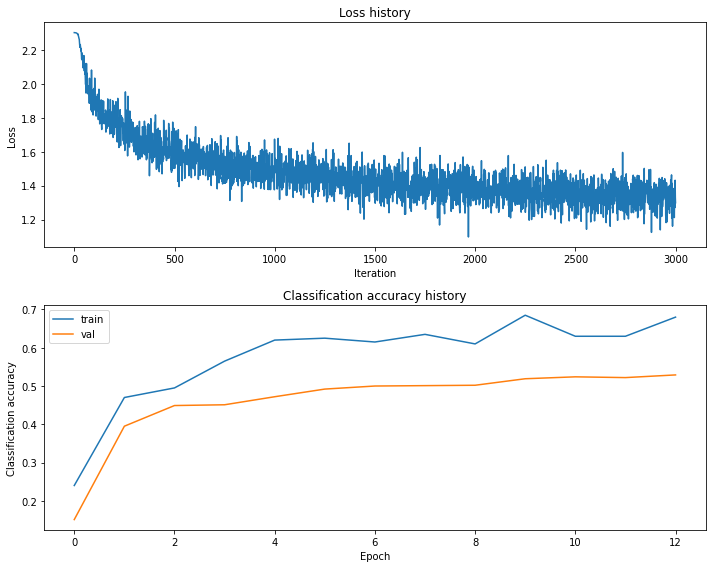

In [15]:
#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
#################################################################################
# *****START OF YOUR CODE*****

input_size = 32 * 32 * 3
hidden_size = 200 # increased number of neurons to increase the capacity of the network
num_classes = 10
best_net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = best_net.train(X_train, y_train, X_val, y_val,
            num_iters=3000, batch_size=200,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# increased number of iterations and increased the learning rate

# Predict on the validation set
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# *****END OF YOUR CODE*****

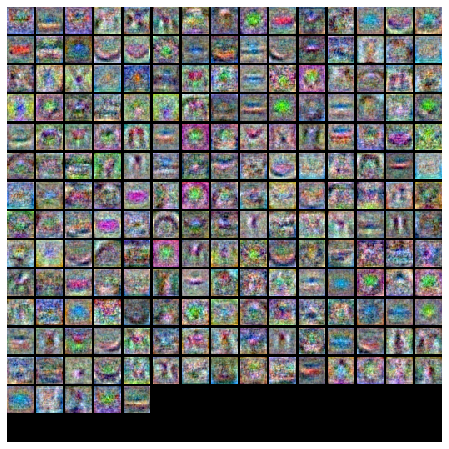

In [16]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained neural network on the test set. We expect to get accuracy above 48%.

In [17]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.547


In [18]:
train_acc = (best_net.predict(X_train) == y_train).mean()
print('Training accuracy: ', train_acc)

Training accuracy:  0.5893877551020408


**Question**

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. Which of the below (possibly multiple) ways can decrease this gap?

1. Increase the regularization strength.
2. Train on a larger dataset.
3. Add more hidden units.
4. None of the above.

$\color{blue}{\textit{Your Answer - Please Explain}}$ 

Among these options, there are two which could decrease this gap: increasing the regularization strengh and training on a larger dataset. We selected the former because an higher regularization strength would help in reducing overfitting, making the model simpler (we recall that among competiting hypotyheses, the simplest is the best - Occam's Razor). We also chose training on a larger dataset because it implies adding more examples and also more diversity. The main risk with few samples is to let the model capture the noise, while with a much larger dataset it is easier for the model to capture right patterns and also the a bigger dataset will make the error closer to the real error.
We did not select adding more hidden units since this would imply having more parameters and so an higher complexity which could lead to overfitting.